In [1]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time

ModuleNotFoundError: No module named 'jax'

# Data Preprocessing

In [2]:
df = pd.read_csv("songsDataset.csv")

# check for null entries
print(f"Null entries: \n{df.isnull().sum()}\n")

# unique users and songs
users = df["'userID'"].unique()
songs = df["'songID'"].sort_values().unique()

# number of users and songs
N_users = len(users)
N_songs = len(songs)
print(f"Number of Users: {N_users}")
print(f"Number of Songs: {N_songs}")

# map original song id to assigned song id
dct = {}
for i in range(len(songs)):
    dct[songs[i]] = i
df["'newSongID'"] = df["'songID'"].apply(lambda x: dct[x])

# train test split dataset
df_test = df.groupby("'songID'").sample(frac = 0.1, random_state = 69)
df_train = df.drop(df_test.index)

df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True).sort_values("'userID'")

Null entries: 
'userID'    0
'songID'    0
'rating'    0
dtype: int64

Number of Users: 200000
Number of Songs: 127771


In [3]:
@jax.jit
def loss(H, W, rating):
    error = jnp.dot(H, W) - rating
    return error**2 + 0.01 * jnp.sum(H**2) + 0.01 * jnp.sum(W**2)

loss_grad = jax.jit(jax.grad(loss, argnums=(0,1)))

In [4]:
@jax.jit
def loss_with_bias(H, W, bu, bi, rating):
    pred = jnp.dot(H, W) + jnp.mean(np.array(df_train["'rating'"])) + bu + bi
    error = jnp.dot(H, W) - rating
    return error**2 + 0.01 * jnp.sum(H**2) + 0.01 * jnp.sum(W**2) + 0.01 * bu**2 + 0.01 * bi**2

loss_grad_with_bias = jax.jit(jax.grad(loss_with_bias, argnums=(0,1,2,3)))

In [5]:
@jax.jit
def mse(H_batch, W_batch, ratings_batch):
    predictions = jnp.sum(H_batch * W_batch, axis=1)
    errors = ratings_batch - predictions
    return jnp.mean(errors**2)

In [6]:
@jax.jit
def mse_with_bias(H_batch, W_batch, bu_batch, bi_batch, ratings_batch):
    predictions = jnp.sum(H_batch * W_batch, axis=1) + bu_batch + bi_batch + jnp.mean(np.array(df_train["'rating'"]))
    errors = ratings_batch - predictions
    return jnp.mean(errors**2)

# Model Building

In [7]:
latent_factors = 10

H_init = np.random.normal(0, 1, size=(N_users, latent_factors)) / np.sqrt(latent_factors)
W_init = np.random.normal(0, 1, size=(N_songs, latent_factors)) / np.sqrt(latent_factors)

## 1. Alternating Least Squares (ALS)

### 1.1. Whole dataset update

In [10]:
n_iter = 5
lr = 0.05

H_als = H_init.copy()
W_als = W_init.copy()

training_losses1 = []
test_losses1 = []

for i in range(n_iter):
    start = time.time()
    
    for user in users:
        V = W_als[df_train[df_train["'userID'"] == user]["'newSongID'"]]
        R = jnp.array(df_train[df_train["'userID'"] == user]["'rating'"])
        
        A = jnp.dot(V.T, V) + 0.1 * jnp.eye(H_als.shape[1])
        b = jnp.dot(V.T, R)
        
        H_als[user] = jnp.linalg.solve(A, b)
    
    for song in songs:
        U = H_als[df_train[df_train["'songID'"] == song]["'userID'"]]
        R = jnp.array(df_train[df_train["'songID'"] == song]["'rating'"])
        
        A = jnp.dot(U.T, U) + 0.1 * jnp.eye(W_als.shape[1])
        b = jnp.dot(U.T, R)
        
        W_als[dct[song]] = jnp.linalg.solve(A, b)
    
    mse_train = mse(H_als[df_train["'userID'"]], W_als[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses1.append(mse_train)
    
    mse_test = mse(H_als[df_test["'userID'"]], W_als[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses1.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 1.0590580701828003, test mse = 34.63175964355469, time taken = 26m 19s
iter 2, training mse = 0.4483702480792999, test mse = 33.35728454589844, time taken = 26m 23s
iter 3, training mse = 0.28932905197143555, test mse = 32.98724365234375, time taken = 25m 45s
iter 4, training mse = 0.2068135142326355, test mse = 32.81015396118164, time taken = 21m 25s
iter 5, training mse = 0.15604673326015472, test mse = 32.70056915283203, time taken = 20m 52s


### 1.2. Sampling update

In [11]:
n_iter = 100
lr = 0.05

H_als_sampled = H_init.copy()
W_als_sampled = W_init.copy()

training_losses2 = []
test_losses2 = []

for i in range(n_iter):
    start = time.time()
    
    cur_users = users[np.random.permutation(len(users))][:5000]
    cur_songs = songs[np.random.permutation(len(songs))][:5000]
    
    for user in cur_users:
        V = W_als_sampled[df_train[df_train["'userID'"] == user]["'newSongID'"]]
        R = jnp.array(df_train[df_train["'userID'"] == user]["'rating'"])
        
        A = jnp.dot(V.T, V) + 0.1 * jnp.eye(H_als_sampled.shape[1])
        b = jnp.dot(V.T, R)
        
        H_als_sampled[user] = jnp.linalg.solve(A, b)
    
    for song in cur_songs:
        U = H_als_sampled[df_train[df_train["'songID'"] == song]["'userID'"]]
        R = jnp.array(df_train[df_train["'songID'"] == song]["'rating'"])
        
        A = jnp.dot(U.T, U) + 0.1 * jnp.eye(W_als_sampled.shape[1])
        b = jnp.dot(U.T, R)
        
        W_als_sampled[dct[song]] = jnp.linalg.solve(A, b)
    
    # calculate mse train
    mse_train = mse(H_als_sampled[df_train["'userID'"]], W_als_sampled[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses2.append(mse_train)
    
    # calculate mse test
    mse_test = mse(H_als_sampled[df_test["'userID'"]], W_als_sampled[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses2.append(mse_test)

    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 13.975611686706543, test mse = 15.670576095581055, time taken = 0m 37s
iter 2, training mse = 13.518240928649902, test mse = 17.889148712158203, time taken = 0m 37s
iter 3, training mse = 13.080144882202148, test mse = 20.48567771911621, time taken = 0m 37s
iter 4, training mse = 12.662958145141602, test mse = 23.56610870361328, time taken = 0m 38s
iter 5, training mse = 12.27016544342041, test mse = 27.566844940185547, time taken = 0m 37s
iter 6, training mse = 11.888521194458008, test mse = 31.895851135253906, time taken = 0m 37s
iter 7, training mse = 11.523773193359375, test mse = 36.49931335449219, time taken = 0m 37s
iter 8, training mse = 11.171744346618652, test mse = 41.601314544677734, time taken = 0m 37s
iter 9, training mse = 10.844762802124023, test mse = 47.0439338684082, time taken = 0m 37s
iter 10, training mse = 10.52574348449707, test mse = 53.35391616821289, time taken = 0m 37s
iter 11, training mse = 10.217697143554688, test mse = 58.769737243

iter 89, training mse = 1.703238606452942, test mse = 123.29141998291016, time taken = 0m 44s
iter 90, training mse = 1.6726231575012207, test mse = 122.46945190429688, time taken = 0m 41s
iter 91, training mse = 1.6405115127563477, test mse = 121.72335815429688, time taken = 0m 42s
iter 92, training mse = 1.6088727712631226, test mse = 120.76175689697266, time taken = 0m 41s
iter 93, training mse = 1.5785201787948608, test mse = 119.91532135009766, time taken = 0m 41s
iter 94, training mse = 1.5486303567886353, test mse = 119.19140625, time taken = 0m 40s
iter 95, training mse = 1.520005702972412, test mse = 118.37678527832031, time taken = 0m 41s
iter 96, training mse = 1.489856481552124, test mse = 117.71510314941406, time taken = 0m 41s
iter 97, training mse = 1.4633318185806274, test mse = 117.01365661621094, time taken = 0m 41s
iter 98, training mse = 1.4370529651641846, test mse = 116.18281555175781, time taken = 0m 40s
iter 99, training mse = 1.4134984016418457, test mse = 115.

## 2. Gradient Descent (GD)

### 2.1. Whole dataset update

In [12]:
n_iter = 15
lr = 0.05

H_gd = H_init.copy()
W_gd = W_init.copy()

training_losses3 = []
test_losses3 = []

for i in range(n_iter):
    start = time.time()
    
    for idx, item in df_train.iterrows():
        uid = item["'userID'"]
        sid = dct[item["'songID'"]]
        rating = item["'rating'"]
        
        # calculate loss and gradient
        H_grad, W_grad = loss_grad(H_gd[uid], W_gd[sid], rating)
        
        # update params
        H_gd[uid] -= lr*H_grad
        W_gd[sid] -= lr*W_grad
        
    # calculate mse train
    mse_train = mse(H_gd[df_train["'userID'"]], W_gd[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses3.append(mse_train)
    
    # calculate mse test
    mse_test = mse(H_gd[df_test["'userID'"]], W_gd[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses3.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 4.605830192565918, test mse = 6.2157301902771, time taken = 3m 47s
iter 2, training mse = 1.9578537940979004, test mse = 4.017765045166016, time taken = 3m 45s
iter 3, training mse = 1.6575050354003906, test mse = 4.147198677062988, time taken = 3m 47s
iter 4, training mse = 1.5168871879577637, test mse = 4.274405002593994, time taken = 3m 44s
iter 5, training mse = 1.4301397800445557, test mse = 4.3872528076171875, time taken = 3m 43s
iter 6, training mse = 1.3669078350067139, test mse = 4.486968517303467, time taken = 3m 45s
iter 7, training mse = 1.3207862377166748, test mse = 4.5714287757873535, time taken = 3m 41s
iter 8, training mse = 1.2828396558761597, test mse = 4.6430277824401855, time taken = 3m 43s
iter 9, training mse = 1.2499234676361084, test mse = 4.706343173980713, time taken = 3m 24s
iter 10, training mse = 1.218281626701355, test mse = 4.7603936195373535, time taken = 3m 21s
iter 11, training mse = 1.1908247470855713, test mse = 4.809012889862

### 2.2. Sampling update

In [13]:
n_iter = 100
lr = 0.01

H_gd_sampled = H_init.copy()
W_gd_sampled = W_init.copy()

training_losses4 = []
test_losses4 = []

for i in range(n_iter):
    start = time.time()
    
    cur_df = df_train.loc[np.random.permutation(len(df_train))][:100000]
    for idx, item in cur_df.iterrows():
        uid = item["'userID'"]
        sid = item["'newSongID'"]
        rating = item["'rating'"]
        
        # calculate loss and gradient
        H_grad, W_grad = loss_grad(H_gd_sampled[uid], W_gd_sampled[sid], rating)
        
        # update params
        H_gd_sampled[uid] -= lr*H_grad
        W_gd_sampled[sid] -= lr*W_grad

    mse_train = mse(H_gd_sampled[df_train["'userID'"]], W_gd_sampled[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses4.append(mse_train)
    
    mse_test = mse(H_gd_sampled[df_test["'userID'"]], W_gd_sampled[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses4.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 14.401576042175293, test mse = 14.669344902038574, time taken = 0m 12s
iter 2, training mse = 14.342740058898926, test mse = 14.672844886779785, time taken = 0m 13s
iter 3, training mse = 14.284299850463867, test mse = 14.677434921264648, time taken = 0m 13s
iter 4, training mse = 14.226739883422852, test mse = 14.682944297790527, time taken = 0m 13s
iter 5, training mse = 14.167776107788086, test mse = 14.689617156982422, time taken = 0m 12s
iter 6, training mse = 14.107604026794434, test mse = 14.697430610656738, time taken = 0m 13s
iter 7, training mse = 14.045948028564453, test mse = 14.704899787902832, time taken = 0m 12s
iter 8, training mse = 13.982873916625977, test mse = 14.713109016418457, time taken = 0m 12s
iter 9, training mse = 13.916590690612793, test mse = 14.719011306762695, time taken = 0m 12s
iter 10, training mse = 13.84644889831543, test mse = 14.729119300842285, time taken = 0m 12s
iter 11, training mse = 13.773978233337402, test mse = 14.74

iter 89, training mse = 2.6355185508728027, test mse = 6.815917491912842, time taken = 0m 13s
iter 90, training mse = 2.583660364151001, test mse = 6.758874893188477, time taken = 0m 13s
iter 91, training mse = 2.5335729122161865, test mse = 6.704535484313965, time taken = 0m 12s
iter 92, training mse = 2.484961748123169, test mse = 6.651991367340088, time taken = 0m 13s
iter 93, training mse = 2.4376330375671387, test mse = 6.600082874298096, time taken = 0m 12s
iter 94, training mse = 2.3912556171417236, test mse = 6.547519207000732, time taken = 0m 12s
iter 95, training mse = 2.3473598957061768, test mse = 6.500892639160156, time taken = 0m 12s
iter 96, training mse = 2.3038642406463623, test mse = 6.451691150665283, time taken = 0m 12s
iter 97, training mse = 2.2612454891204834, test mse = 6.406644821166992, time taken = 0m 12s
iter 98, training mse = 2.2199294567108154, test mse = 6.362009525299072, time taken = 0m 12s
iter 99, training mse = 2.1796863079071045, test mse = 6.32044

## 3. Gradient Descent with Bias Terms

### 3.1. Whole dataset

In [14]:
n_iter = 15
lr = 0.05

H_gd_with_bias = H_init.copy()
W_gd_with_bias = W_init.copy()
bu = np.zeros(N_users)
bi = np.zeros(N_songs)

training_losses5 = []
test_losses5 = []

for i in range(n_iter):
    start = time.time()
    
    for idx, item in df_train.iterrows():
        uid = item["'userID'"]
        sid = item["'newSongID'"]
        rating = item["'rating'"]
        
        # calculate loss and gradient
        H_grad, W_grad, bu_grad, bi_grad = loss_grad_with_bias(H_gd_with_bias[uid], W_gd_with_bias[sid], bu[uid], bi[sid], rating)
        
        # update params
        H_gd_with_bias[uid] -= lr*H_grad
        W_gd_with_bias[sid] -= lr*W_grad
        bu[uid] -= lr*bu_grad
        bi[sid] -= lr*bi_grad

    mse_train = mse_with_bias(H_gd_with_bias[df_train["'userID'"]], W_gd_with_bias[df_train["'newSongID'"]], bu[df_train["'userID'"]], bi[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses5.append(mse_train)
    
    mse_test = mse_with_bias(H_gd_with_bias[df_test["'userID'"]], W_gd_with_bias[df_test["'newSongID'"]], bu[df_test["'userID'"]], bi[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses5.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 13.174217224121094, test mse = 12.179637908935547, time taken = 7m 1s
iter 2, training mse = 12.089499473571777, test mse = 11.215559959411621, time taken = 7m 0s
iter 3, training mse = 11.970335960388184, test mse = 11.452473640441895, time taken = 6m 39s
iter 4, training mse = 12.145071029663086, test mse = 11.911762237548828, time taken = 6m 26s
iter 5, training mse = 12.279143333435059, test mse = 12.288409233093262, time taken = 6m 20s


KeyboardInterrupt: 

### 3.2. Sampling update

In [15]:
n_iter = 100
lr = 0.05

H_gd_with_bias_sampled = H_init.copy()
W_gd_with_bias_sampled = W_init.copy()
bu_sampled = np.zeros(N_users)
bi_sampled = np.zeros(N_songs)

training_losses6 = []
test_losses6 = []

for i in range(n_iter):
    start = time.time()
    
    cur_df = df_train.loc[np.random.permutation(len(df_train))][:100000]
    
    for idx, item in cur_df.iterrows():
        uid = item["'userID'"]
        sid = item["'newSongID'"]
        rating = item["'rating'"]
        
        # calculate loss and gradient
        H_grad, W_grad, bu_grad, bi_grad = loss_grad_with_bias(H_gd_with_bias_sampled[uid], W_gd_with_bias_sampled[sid], bu_sampled[uid], bi_sampled[sid], rating)
        
        # update params
        H_gd_with_bias_sampled[uid] -= lr*H_grad
        W_gd_with_bias_sampled[sid] -= lr*W_grad
        bu_sampled[uid] -= lr*bu_grad
        bi_sampled[sid] -= lr*bi_grad

    mse_train = mse_with_bias(H_gd_with_bias_sampled[df_train["'userID'"]], W_gd_with_bias_sampled[df_train["'newSongID'"]], bu_sampled[df_train["'userID'"]], bi_sampled[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses6.append(mse_train)
    
    mse_test = mse_with_bias(H_gd_with_bias_sampled[df_test["'userID'"]], W_gd_with_bias_sampled[df_test["'newSongID'"]], bu_sampled[df_test["'userID'"]], bi_sampled[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses6.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 2.6273233890533447, test mse = 2.6139628887176514, time taken = 0m 22s
iter 2, training mse = 2.7888247966766357, test mse = 2.7623534202575684, time taken = 0m 22s
iter 3, training mse = 3.036825180053711, test mse = 2.9617559909820557, time taken = 0m 21s
iter 4, training mse = 3.375307083129883, test mse = 3.21732234954834, time taken = 0m 21s
iter 5, training mse = 3.877875566482544, test mse = 3.5689334869384766, time taken = 0m 21s
iter 6, training mse = 4.433660984039307, test mse = 3.9519927501678467, time taken = 0m 21s
iter 7, training mse = 5.086354732513428, test mse = 4.41472053527832, time taken = 0m 21s
iter 8, training mse = 5.8089919090271, test mse = 4.9215006828308105, time taken = 0m 21s
iter 9, training mse = 6.502706527709961, test mse = 5.408348560333252, time taken = 0m 21s
iter 10, training mse = 7.201465129852295, test mse = 5.92183256149292, time taken = 0m 22s
iter 11, training mse = 7.739206790924072, test mse = 6.329694747924805, tim

KeyboardInterrupt: 

# Evaluation

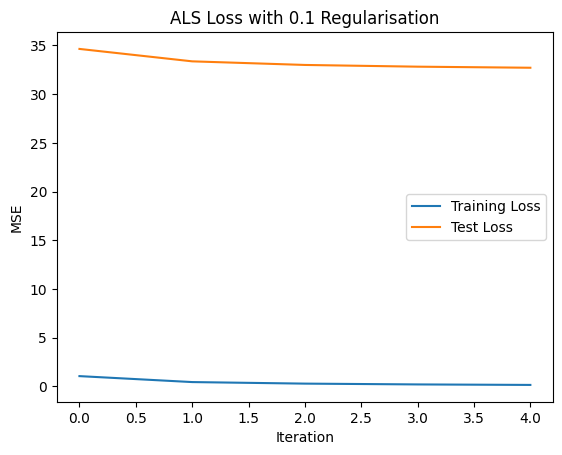

In [22]:
plt.plot(training_losses1, label="Training Loss")
plt.plot(test_losses1, label="Test Loss")
plt.title("ALS Loss with 0.1 Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

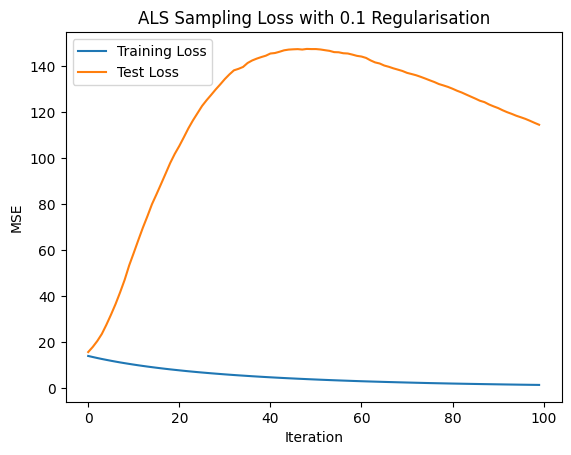

In [23]:
plt.plot(training_losses2, label="Training Loss")
plt.plot(test_losses2, label="Test Loss")
plt.title("ALS Sampling Loss with 0.1 Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

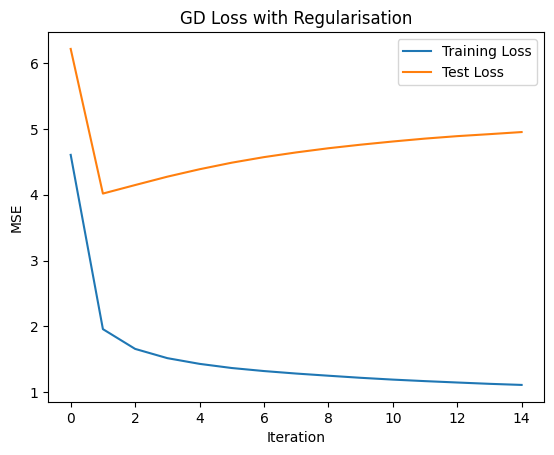

In [18]:
plt.plot(training_losses3, label="Training Loss")
plt.plot(test_losses3, label="Test Loss")
plt.title("GD Loss with Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

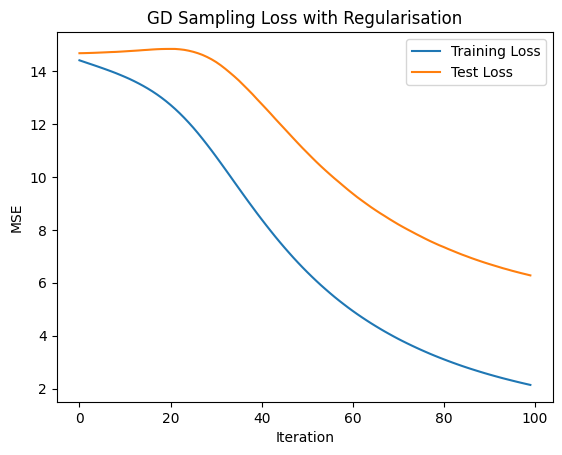

In [19]:
plt.plot(training_losses4, label="Training Loss")
plt.plot(test_losses4, label="Test Loss")
plt.title("GD Sampling Loss with Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

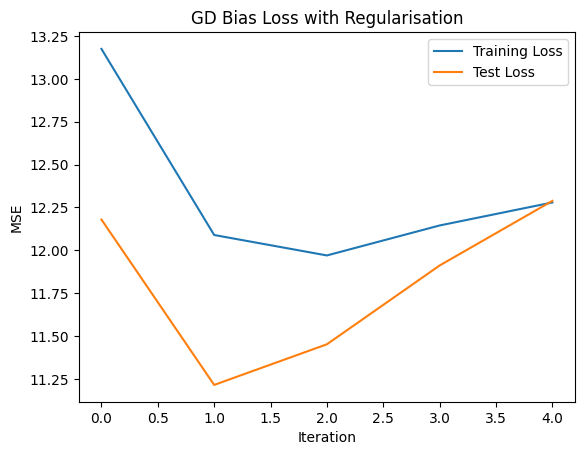

In [20]:
plt.plot(training_losses5, label="Training Loss")
plt.plot(test_losses5, label="Test Loss")
plt.title("GD Bias Loss with Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

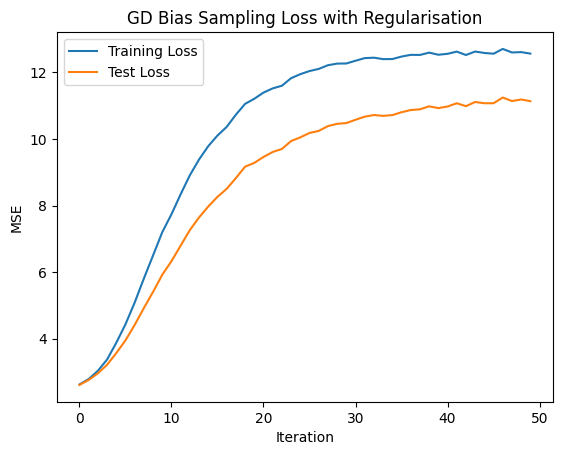

In [21]:
plt.plot(training_losses6, label="Training Loss")
plt.plot(test_losses6, label="Test Loss")
plt.title("GD Bias Sampling Loss with Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()